In [1]:
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import time
import os
from IPython import display
from keras import backend
from keras.constraints import Constraint

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100
num_examples_to_generate = 16

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [7]:
def discriminator_loss(real_output, fake_output):
    total_loss = -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)
    return total_loss


def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [8]:
#from tutorial
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [9]:

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.00005)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.00005)

In [10]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [11]:
# from tutorial
@tf.function
def train_step(images, generator, discriminator):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

In [12]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if (epoch==1) or (epoch%10==0):
    plt.savefig('/content/drive/MyDrive/'+model_+'_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

  

In [13]:
# from tutorial
def train(dataset, epochs, generator, discriminator):

  for epoch in range(epochs):
    start = time.time()

    # train
    loss_train = []
    for image_batch in dataset:
      loss_train.append(train_step(image_batch, generator, discriminator))

    train_loss.loc[len(train_loss)] = np.mean(loss_train, axis=0)

    # tensorboard
    with gen_summary_writer.as_default():
        tf.summary.scalar('generator_loss', train_loss.gen_loss.values[-1], step=epoch)
    with disc_summary_writer.as_default():
        tf.summary.scalar('discrinimator_loss', train_loss.disc_loss.values[-1], step=epoch)

=
    if (epoch==1) or (epoch%10==0):
        generate_and_save_images(generator,
                             epoch,
                             seed)
    
    print('Time for epoch {} is {} sec, generation loss: {}, discrimination loss: {}'.format(epoch + 1, time.time()-start, train_loss.gen_loss.values[-1], train_loss.disc_loss.values[-1]))

  # Generate after the final epoch
  
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
  return 
  



In [14]:
def summary_writer(dir):
    return(tf.summary.create_file_writer(dir))


In [15]:
%load_ext tensorboard

In [16]:
train_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
test_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [17]:
def make_generator_model():

  model = tf.keras.Sequential()
  model.add(layers.Dense(128, input_shape=(100,)))
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(7*7*128))
  model.add(layers.BatchNormalization())

  model.add(layers.Reshape((7, 7, 128)))

  model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

  assert model.output_shape == (None, 28, 28, 1)


  return model

In [18]:
def make_discriminator_model():

  const = ClipConstraint(0.01)
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5),kernel_constraint=const, strides=(2, 2), padding='same',
                                    input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5),kernel_constraint=const, strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())

  model.add(layers.Dense(1024,kernel_constraint=const))
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(256,kernel_constraint=const))
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(1,kernel_constraint=const))
  #model.add(layers.Activation('sigmoid'))

  return model

In [19]:
generator = make_generator_model()
discriminator = make_discriminator_model()

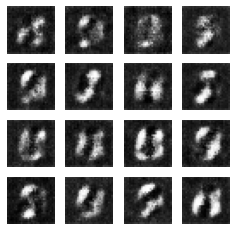

Time for epoch 1 is 16.787485599517822 sec, generation loss: -0.1811373084783554, discrimination loss: -3.9760830402374268


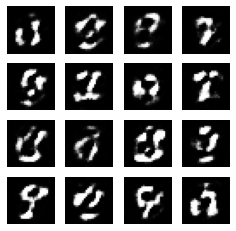

Time for epoch 2 is 12.35883378982544 sec, generation loss: -0.15356941521167755, discrimination loss: -13.240994453430176
Time for epoch 3 is 11.73371148109436 sec, generation loss: -0.14651846885681152, discrimination loss: -15.732818603515625
Time for epoch 4 is 11.352481603622437 sec, generation loss: -0.16478008031845093, discrimination loss: -16.590375900268555
Time for epoch 5 is 11.163413524627686 sec, generation loss: -0.19217993319034576, discrimination loss: -16.603595733642578
Time for epoch 6 is 11.112821102142334 sec, generation loss: -0.20995759963989258, discrimination loss: -16.732532501220703
Time for epoch 7 is 11.136127233505249 sec, generation loss: -0.21930734813213348, discrimination loss: -16.803436279296875
Time for epoch 8 is 11.20100474357605 sec, generation loss: -0.2075558304786682, discrimination loss: -16.603429794311523
Time for epoch 9 is 11.36336350440979 sec, generation loss: -0.1991083025932312, discrimination loss: -16.015308380126953
Time for epoch

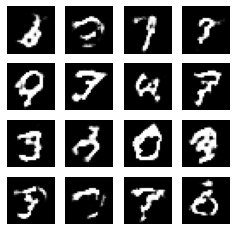

Time for epoch 11 is 11.766467094421387 sec, generation loss: -0.19696775078773499, discrimination loss: -16.479169845581055
Time for epoch 12 is 11.257754564285278 sec, generation loss: -0.19324932992458344, discrimination loss: -15.481252670288086
Time for epoch 13 is 11.21470594406128 sec, generation loss: -0.18125538527965546, discrimination loss: -15.036513328552246
Time for epoch 14 is 11.225995302200317 sec, generation loss: -0.18629668653011322, discrimination loss: -15.028658866882324
Time for epoch 15 is 11.215758562088013 sec, generation loss: -0.1715673804283142, discrimination loss: -14.336459159851074
Time for epoch 16 is 11.223645210266113 sec, generation loss: -0.16890713572502136, discrimination loss: -13.69431209564209
Time for epoch 17 is 11.237422227859497 sec, generation loss: -0.16458295285701752, discrimination loss: -13.189538955688477
Time for epoch 18 is 11.259031057357788 sec, generation loss: -0.1787232905626297, discrimination loss: -12.649527549743652
Time

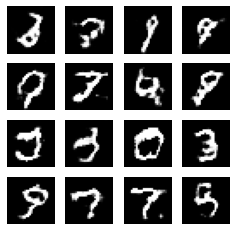

Time for epoch 21 is 11.840794563293457 sec, generation loss: -0.1849769800901413, discrimination loss: -12.895635604858398
Time for epoch 22 is 11.263628482818604 sec, generation loss: -0.16263791918754578, discrimination loss: -11.787859916687012
Time for epoch 23 is 11.254289388656616 sec, generation loss: -0.16564172506332397, discrimination loss: -11.582833290100098
Time for epoch 24 is 11.260196208953857 sec, generation loss: -0.17185525596141815, discrimination loss: -11.510287284851074
Time for epoch 25 is 11.262166023254395 sec, generation loss: -0.1860220730304718, discrimination loss: -12.153422355651855
Time for epoch 26 is 11.274791955947876 sec, generation loss: -0.15770159661769867, discrimination loss: -11.153287887573242
Time for epoch 27 is 11.294378280639648 sec, generation loss: -0.1686488389968872, discrimination loss: -11.053746223449707
Time for epoch 28 is 11.277973651885986 sec, generation loss: -0.19960512220859528, discrimination loss: -11.296615600585938
Tim

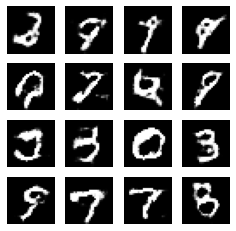

Time for epoch 31 is 11.706071138381958 sec, generation loss: -0.18983903527259827, discrimination loss: -12.054535865783691
Time for epoch 32 is 11.271354675292969 sec, generation loss: -0.18272458016872406, discrimination loss: -12.703710556030273
Time for epoch 33 is 11.271477937698364 sec, generation loss: -0.17109522223472595, discrimination loss: -12.485013008117676
Time for epoch 34 is 11.28731918334961 sec, generation loss: -0.16154205799102783, discrimination loss: -11.841695785522461
Time for epoch 35 is 11.259835958480835 sec, generation loss: -0.15081964433193207, discrimination loss: -11.521500587463379
Time for epoch 36 is 11.240922451019287 sec, generation loss: -0.1520550698041916, discrimination loss: -12.183573722839355
Time for epoch 37 is 11.234715223312378 sec, generation loss: -0.1679927259683609, discrimination loss: -11.503410339355469
Time for epoch 38 is 11.218764543533325 sec, generation loss: -0.14586570858955383, discrimination loss: -11.703001976013184
Tim

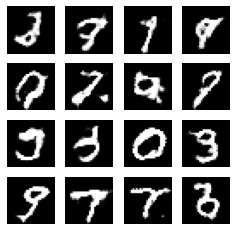

Time for epoch 41 is 11.688058853149414 sec, generation loss: -0.1630791425704956, discrimination loss: -11.751605987548828
Time for epoch 42 is 11.273284435272217 sec, generation loss: -0.14062048494815826, discrimination loss: -12.214591979980469
Time for epoch 43 is 11.255026817321777 sec, generation loss: -0.1308818906545639, discrimination loss: -10.844147682189941
Time for epoch 44 is 11.243935108184814 sec, generation loss: -0.17432494461536407, discrimination loss: -11.775959968566895
Time for epoch 45 is 11.238208770751953 sec, generation loss: -0.14873892068862915, discrimination loss: -11.427743911743164
Time for epoch 46 is 11.224087476730347 sec, generation loss: -0.15581561625003815, discrimination loss: -11.231133460998535
Time for epoch 47 is 11.233455896377563 sec, generation loss: -0.13102373480796814, discrimination loss: -10.899445533752441
Time for epoch 48 is 11.245494365692139 sec, generation loss: -0.1440846472978592, discrimination loss: -11.413155555725098
Tim

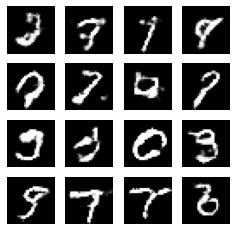

Time for epoch 51 is 11.81526780128479 sec, generation loss: -0.1677071750164032, discrimination loss: -11.352190971374512
Time for epoch 52 is 11.2261061668396 sec, generation loss: -0.16471171379089355, discrimination loss: -10.561988830566406
Time for epoch 53 is 11.238000631332397 sec, generation loss: -0.10927549004554749, discrimination loss: -11.034078598022461
Time for epoch 54 is 11.243430852890015 sec, generation loss: -0.15042594075202942, discrimination loss: -10.882100105285645
Time for epoch 55 is 11.260977506637573 sec, generation loss: -0.12440614402294159, discrimination loss: -10.279088973999023
Time for epoch 56 is 11.27217984199524 sec, generation loss: -0.1439833641052246, discrimination loss: -11.199365615844727
Time for epoch 57 is 11.272602558135986 sec, generation loss: -0.14791712164878845, discrimination loss: -10.452345848083496
Time for epoch 58 is 11.242996454238892 sec, generation loss: -0.15714353322982788, discrimination loss: -10.693686485290527
Time f

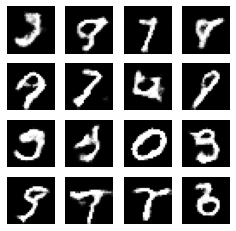

Time for epoch 61 is 11.653644323348999 sec, generation loss: -0.11703882366418839, discrimination loss: -10.652823448181152
Time for epoch 62 is 11.217457056045532 sec, generation loss: -0.14329761266708374, discrimination loss: -11.468250274658203
Time for epoch 63 is 11.229532957077026 sec, generation loss: -0.1290580928325653, discrimination loss: -11.37136173248291
Time for epoch 64 is 11.234328985214233 sec, generation loss: -0.12788961827754974, discrimination loss: -10.849939346313477
Time for epoch 65 is 11.241352081298828 sec, generation loss: -0.1175384595990181, discrimination loss: -11.444870948791504
Time for epoch 66 is 11.254514455795288 sec, generation loss: -0.14408470690250397, discrimination loss: -10.523138046264648
Time for epoch 67 is 11.257007837295532 sec, generation loss: -0.11432413011789322, discrimination loss: -10.213555335998535
Time for epoch 68 is 11.268065452575684 sec, generation loss: -0.13613742589950562, discrimination loss: -10.874873161315918
Tim

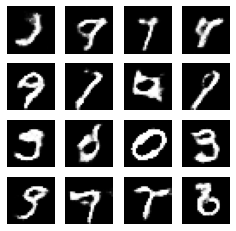

Time for epoch 71 is 11.665489196777344 sec, generation loss: -0.15727074444293976, discrimination loss: -10.81354808807373
Time for epoch 72 is 11.316660404205322 sec, generation loss: -0.09978409111499786, discrimination loss: -11.199427604675293
Time for epoch 73 is 11.19747543334961 sec, generation loss: -0.14573292434215546, discrimination loss: -10.313031196594238
Time for epoch 74 is 11.22683334350586 sec, generation loss: -0.13152755796909332, discrimination loss: -10.515515327453613
Time for epoch 75 is 11.253383874893188 sec, generation loss: -0.08578729629516602, discrimination loss: -10.437100410461426
Time for epoch 76 is 11.306354999542236 sec, generation loss: -0.11283638328313828, discrimination loss: -10.407485008239746
Time for epoch 77 is 11.267083168029785 sec, generation loss: -0.1509275734424591, discrimination loss: -9.588181495666504
Time for epoch 78 is 11.21889328956604 sec, generation loss: -0.12096729129552841, discrimination loss: -10.414413452148438
Time f

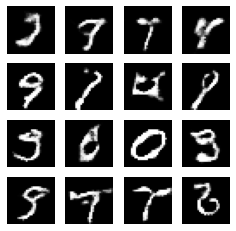

Time for epoch 81 is 11.691697835922241 sec, generation loss: -0.10256852209568024, discrimination loss: -10.560129165649414
Time for epoch 82 is 11.271556377410889 sec, generation loss: -0.09478377550840378, discrimination loss: -9.794240951538086
Time for epoch 83 is 11.274993181228638 sec, generation loss: -0.11140476912260056, discrimination loss: -10.170644760131836
Time for epoch 84 is 11.312550783157349 sec, generation loss: -0.1026790663599968, discrimination loss: -9.579059600830078
Time for epoch 85 is 11.306869983673096 sec, generation loss: -0.11596636474132538, discrimination loss: -10.664741516113281
Time for epoch 86 is 11.256926536560059 sec, generation loss: -0.10070987790822983, discrimination loss: -10.093594551086426
Time for epoch 87 is 11.221365213394165 sec, generation loss: -0.13759835064411163, discrimination loss: -10.042120933532715
Time for epoch 88 is 11.215304136276245 sec, generation loss: -0.0908002033829689, discrimination loss: -9.897323608398438
Time 

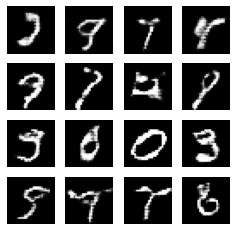

Time for epoch 91 is 11.734462261199951 sec, generation loss: -0.10573562234640121, discrimination loss: -9.722769737243652
Time for epoch 92 is 11.313762903213501 sec, generation loss: -0.12532489001750946, discrimination loss: -8.922942161560059
Time for epoch 93 is 11.293548822402954 sec, generation loss: -0.09005168825387955, discrimination loss: -8.86271858215332
Time for epoch 94 is 11.254228591918945 sec, generation loss: -0.09425324946641922, discrimination loss: -8.577552795410156
Time for epoch 95 is 11.234554529190063 sec, generation loss: -0.10444512218236923, discrimination loss: -8.66435718536377
Time for epoch 96 is 11.227067232131958 sec, generation loss: -0.1335853934288025, discrimination loss: -8.221481323242188
Time for epoch 97 is 11.227020740509033 sec, generation loss: -0.07971227169036865, discrimination loss: -8.830204963684082
Time for epoch 98 is 11.2680983543396 sec, generation loss: -0.1118413507938385, discrimination loss: -7.895523548126221
Time for epoch

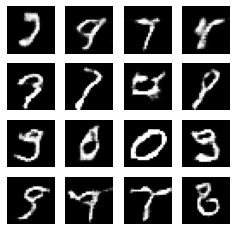

Time for epoch 101 is 11.856809139251709 sec, generation loss: -0.11317851394414902, discrimination loss: -7.858804702758789
Time for epoch 102 is 11.27060604095459 sec, generation loss: -0.11666231602430344, discrimination loss: -6.499290943145752
Time for epoch 103 is 11.292071342468262 sec, generation loss: -0.09472938627004623, discrimination loss: -7.599039077758789
Time for epoch 104 is 11.273011922836304 sec, generation loss: -0.13002222776412964, discrimination loss: -6.2099480628967285
Time for epoch 105 is 11.292192697525024 sec, generation loss: -0.11870410293340683, discrimination loss: -5.976860046386719
Time for epoch 106 is 11.288244247436523 sec, generation loss: -0.08419330418109894, discrimination loss: -6.351563930511475
Time for epoch 107 is 11.280176162719727 sec, generation loss: -0.13572609424591064, discrimination loss: -6.055515289306641
Time for epoch 108 is 11.26893162727356 sec, generation loss: -0.11698999255895615, discrimination loss: -5.589913368225098
T

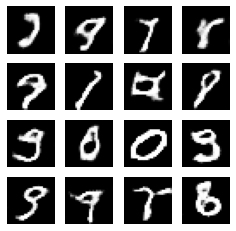

Time for epoch 111 is 11.721699714660645 sec, generation loss: -0.10892567038536072, discrimination loss: -5.388545513153076
Time for epoch 112 is 11.22628140449524 sec, generation loss: -0.06344620883464813, discrimination loss: -4.398654937744141
Time for epoch 113 is 11.254695177078247 sec, generation loss: -0.0926208645105362, discrimination loss: -2.0861289501190186
Time for epoch 114 is 11.255082845687866 sec, generation loss: -0.046741243451833725, discrimination loss: -2.061739683151245
Time for epoch 115 is 11.220946788787842 sec, generation loss: -0.08430922776460648, discrimination loss: -2.142957925796509
Time for epoch 116 is 11.252047538757324 sec, generation loss: -0.06898348033428192, discrimination loss: -1.9856268167495728
Time for epoch 117 is 11.259265184402466 sec, generation loss: -0.0708899199962616, discrimination loss: -1.7614258527755737
Time for epoch 118 is 11.245370388031006 sec, generation loss: -0.07611890882253647, discrimination loss: -1.660841822624206

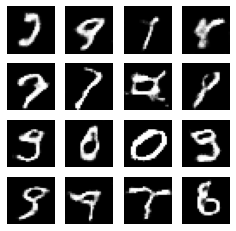

Time for epoch 121 is 11.764255046844482 sec, generation loss: -0.08562294393777847, discrimination loss: -1.8350342512130737
Time for epoch 122 is 11.29284119606018 sec, generation loss: -0.07918214797973633, discrimination loss: -2.0480120182037354
Time for epoch 123 is 11.29688310623169 sec, generation loss: -0.07666802406311035, discrimination loss: -1.3375434875488281
Time for epoch 124 is 11.287735223770142 sec, generation loss: -0.11125528067350388, discrimination loss: -3.31774640083313
Time for epoch 125 is 11.295125722885132 sec, generation loss: -0.08693423867225647, discrimination loss: -3.203901767730713
Time for epoch 126 is 11.304283857345581 sec, generation loss: -0.08677434921264648, discrimination loss: -1.1330816745758057
Time for epoch 127 is 11.301668882369995 sec, generation loss: -0.10362228751182556, discrimination loss: -2.4908447265625
Time for epoch 128 is 11.297209739685059 sec, generation loss: -0.08670847117900848, discrimination loss: -2.06563138961792
Ti

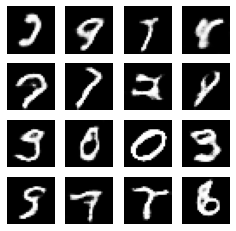

Time for epoch 131 is 11.865512132644653 sec, generation loss: -0.07720335572957993, discrimination loss: -1.8936684131622314
Time for epoch 132 is 11.252140522003174 sec, generation loss: -0.09197527170181274, discrimination loss: -2.1178267002105713
Time for epoch 133 is 11.235528707504272 sec, generation loss: -0.08640360832214355, discrimination loss: -1.820224642753601
Time for epoch 134 is 11.265055894851685 sec, generation loss: -0.11048325151205063, discrimination loss: -1.8550060987472534
Time for epoch 135 is 11.255273580551147 sec, generation loss: -0.08814378827810287, discrimination loss: -1.5871025323867798
Time for epoch 136 is 11.266415119171143 sec, generation loss: -0.11219123750925064, discrimination loss: 0.1026400774717331
Time for epoch 137 is 11.28154730796814 sec, generation loss: -0.11119410395622253, discrimination loss: -1.5924967527389526
Time for epoch 138 is 11.319368839263916 sec, generation loss: -0.10274086892604828, discrimination loss: -0.744073927402

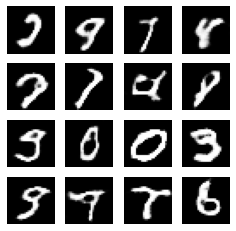

Time for epoch 141 is 11.747721195220947 sec, generation loss: -0.11431148648262024, discrimination loss: 0.4784203767776489
Time for epoch 142 is 11.258644819259644 sec, generation loss: -0.11247746646404266, discrimination loss: 0.30762797594070435
Time for epoch 143 is 11.28013825416565 sec, generation loss: -0.13373053073883057, discrimination loss: -0.03238249570131302
Time for epoch 144 is 11.286059141159058 sec, generation loss: -0.13437102735042572, discrimination loss: -1.070111870765686
Time for epoch 145 is 11.2473623752594 sec, generation loss: -0.09800030291080475, discrimination loss: -0.476342111825943
Time for epoch 146 is 11.269535779953003 sec, generation loss: -0.12423300743103027, discrimination loss: 0.32870957255363464
Time for epoch 147 is 11.252596616744995 sec, generation loss: -0.13877271115779877, discrimination loss: -0.16125519573688507
Time for epoch 148 is 11.251940727233887 sec, generation loss: -0.10949238389730453, discrimination loss: -2.2040176391601

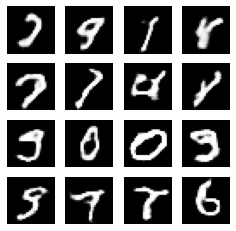

Time for epoch 151 is 11.751390218734741 sec, generation loss: -0.12820516526699066, discrimination loss: -1.136756420135498
Time for epoch 152 is 11.355424642562866 sec, generation loss: -0.1293611228466034, discrimination loss: -1.6696330308914185
Time for epoch 153 is 11.246418237686157 sec, generation loss: -0.1364731341600418, discrimination loss: -0.8443126082420349
Time for epoch 154 is 11.248950004577637 sec, generation loss: -0.1214294582605362, discrimination loss: -0.5531768202781677
Time for epoch 155 is 11.27811074256897 sec, generation loss: -0.1220393255352974, discrimination loss: -0.46809908747673035
Time for epoch 156 is 11.288461446762085 sec, generation loss: -0.12372556328773499, discrimination loss: -0.22695130109786987
Time for epoch 157 is 11.288931369781494 sec, generation loss: -0.11509687453508377, discrimination loss: -1.8021469116210938
Time for epoch 158 is 11.265749454498291 sec, generation loss: -0.11991061270236969, discrimination loss: -0.4388253986835

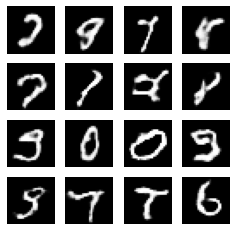

Time for epoch 161 is 11.734642505645752 sec, generation loss: -0.12555238604545593, discrimination loss: -1.44425630569458
Time for epoch 162 is 11.262814998626709 sec, generation loss: -0.12872770428657532, discrimination loss: -2.614088773727417
Time for epoch 163 is 11.247387647628784 sec, generation loss: -0.12993206083774567, discrimination loss: -0.7969657182693481
Time for epoch 164 is 11.22706389427185 sec, generation loss: -0.12984296679496765, discrimination loss: -1.1550135612487793
Time for epoch 165 is 11.257606506347656 sec, generation loss: -0.12724603712558746, discrimination loss: -0.7932841777801514
Time for epoch 166 is 11.234650611877441 sec, generation loss: -0.109731525182724, discrimination loss: 0.6053000092506409
Time for epoch 167 is 11.255326986312866 sec, generation loss: -0.12475722283124924, discrimination loss: 0.46679937839508057
Time for epoch 168 is 11.260379076004028 sec, generation loss: -0.14545826613903046, discrimination loss: -1.415428876876831


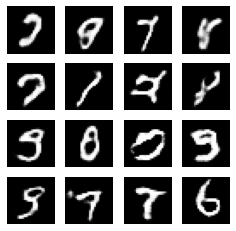

Time for epoch 171 is 11.736412763595581 sec, generation loss: -0.13205495476722717, discrimination loss: -2.0697529315948486
Time for epoch 172 is 11.27650499343872 sec, generation loss: -0.1422872394323349, discrimination loss: -3.3333003520965576
Time for epoch 173 is 11.260744094848633 sec, generation loss: -0.1271888017654419, discrimination loss: -2.6270315647125244
Time for epoch 174 is 11.289460182189941 sec, generation loss: -0.13455387949943542, discrimination loss: -2.717874050140381
Time for epoch 175 is 11.339248895645142 sec, generation loss: -0.12755927443504333, discrimination loss: -1.7198066711425781
Time for epoch 176 is 11.284754514694214 sec, generation loss: -0.11527931690216064, discrimination loss: -5.058259010314941
Time for epoch 177 is 11.249992609024048 sec, generation loss: -0.16189047694206238, discrimination loss: -3.566699743270874
Time for epoch 178 is 11.26797890663147 sec, generation loss: -0.1109674721956253, discrimination loss: -1.4686208963394165


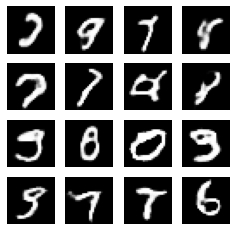

Time for epoch 181 is 11.890281915664673 sec, generation loss: -0.1392154097557068, discrimination loss: -3.251375675201416
Time for epoch 182 is 11.296188592910767 sec, generation loss: -0.1411736011505127, discrimination loss: -4.580907821655273
Time for epoch 183 is 11.286783695220947 sec, generation loss: -0.10233082622289658, discrimination loss: -1.0988434553146362
Time for epoch 184 is 11.29032826423645 sec, generation loss: -0.13775502145290375, discrimination loss: -1.2934050559997559
Time for epoch 185 is 11.283960819244385 sec, generation loss: -0.1375374048948288, discrimination loss: -4.183538436889648
Time for epoch 186 is 11.26478886604309 sec, generation loss: -0.12398845702409744, discrimination loss: -3.4524779319763184
Time for epoch 187 is 11.282140493392944 sec, generation loss: -0.12483163177967072, discrimination loss: 0.34802818298339844
Time for epoch 188 is 11.31847620010376 sec, generation loss: -0.13896186649799347, discrimination loss: -2.8472251892089844
T

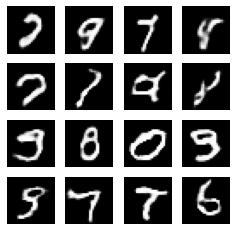

Time for epoch 191 is 11.745755672454834 sec, generation loss: -0.13414573669433594, discrimination loss: -1.839951515197754
Time for epoch 192 is 11.243578672409058 sec, generation loss: -0.13906748592853546, discrimination loss: -1.665159821510315
Time for epoch 193 is 11.27604079246521 sec, generation loss: -0.12908920645713806, discrimination loss: -2.90924334526062
Time for epoch 194 is 11.317716360092163 sec, generation loss: -0.14516887068748474, discrimination loss: -1.9501255750656128
Time for epoch 195 is 11.310271263122559 sec, generation loss: -0.13678252696990967, discrimination loss: -5.521101474761963
Time for epoch 196 is 11.278526544570923 sec, generation loss: -0.12511472404003143, discrimination loss: -1.5144139528274536
Time for epoch 197 is 11.266120910644531 sec, generation loss: -0.13611812889575958, discrimination loss: -3.4784739017486572
Time for epoch 198 is 11.247814655303955 sec, generation loss: -0.14120937883853912, discrimination loss: -3.924335718154907

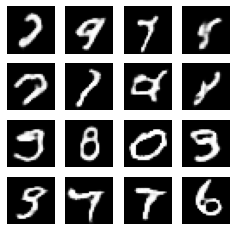

In [20]:
gen_log_dir = 'logs/gradient_tape/GAN_gen'
disc_log_dir = 'logs/gradient_tape/GAN_disc'
gen_summary_writer = summary_writer(gen_log_dir)
disc_summary_writer = summary_writer(disc_log_dir)
train_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
test_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
model_='w_model'
train(train_dataset, 200, generator, discriminator)


In [23]:
%tensorboard --logdir {'/content/logs/gradient_tape'}